# Librerias

In [7]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
import math
import librosa
import scipy.signal
import os
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.signal
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import torchaudio.transforms as T
import torch.nn.functional as F
from scipy.signal import resample
from tqdm import tqdm
from geomloss import SamplesLoss
import os
import time
from tqdm import tqdm
import csv
import geomloss
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def set_all_seeds(num):
    random.seed(num)
    np.random.seed(num)
    torch.manual_seed(num)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(num)

set_all_seeds(42)

## Configuración inicial para generar dataset sinteticos

In [3]:
base_path = "./features/time_domain_win_cut_pad/"
categories = ["chew", "elpp", "shiv"]
file_limit = 4266  
grouped_files = defaultdict(list)

if not os.path.exists(base_path):
    print(f"Error: Directory '{base_path}' not found.")
    exit()

print(f"Scanning directory: {base_path}\n")

for root, dirs, files in os.walk(base_path):
    folder_name = os.path.basename(root)
    
    if folder_name in categories:
        print(f"Processing folder: {folder_name}, Found {len(files)} files.")

        for file in files:
            if file.endswith(".pt") and len(grouped_files[folder_name]) < file_limit:
                file_path = os.path.join(root, file)
                grouped_files[folder_name].append(file_path)
                print(f"Added {file} to category '{folder_name}'")

Scanning directory: ./features/time_domain_win_cut_pad/

Processing folder: chew, Found 4266 files.
Added C3-CZ_0.0_21.0048.pt to category 'chew'
Added C3-CZ_0.2405_2.5624.pt to category 'chew'
Added C3-CZ_10.4038_12.6573.pt to category 'chew'
Added C3-CZ_100.0431_110.1627.pt to category 'chew'
Added C3-CZ_1002.0443_1005.8908.pt to category 'chew'
Added C3-CZ_1007.3117_1010.1994.pt to category 'chew'
Added C3-CZ_1026.2655_1029.0685.pt to category 'chew'
Added C3-CZ_105.0722_110.9278.pt to category 'chew'
Added C3-CZ_105.7222_115.6.pt to category 'chew'
Added C3-CZ_1067.0648_1079.0259.pt to category 'chew'
Added C3-CZ_1086.1008_1120.6059.pt to category 'chew'
Added C3-CZ_1130.2026_1142.4228.pt to category 'chew'
Added C3-CZ_114.0141_129.7887.pt to category 'chew'
Added C3-CZ_114.0481_119.7789.pt to category 'chew'
Added C3-CZ_115.0957_119.5215.pt to category 'chew'
Added C3-CZ_115.2294_179.9893.pt to category 'chew'
Added C3-CZ_1152.0601_1154.6503.pt to category 'chew'
Added C3-CZ_116.1

In [4]:
chew_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['chew']], axis=0)
elpp_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['elpp']], axis=0)
shiv_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['shiv']], axis=0)

In [5]:
print(chew_data.shape)
print(elpp_data.shape)
print(shiv_data.shape)

(4266, 512)
(156, 512)
(2762, 512)


In [6]:
EEG_PATH = 'data'
EOG_ALL_EPOCHS = 'EOG_all_epochs.npy'
EMG_ALL_EPOCHS = 'EMG_all_epochs.npy'
EEG_ALL_EPOCHS = 'EEG_all_epochs.npy'

In [7]:
def show_data_informations(signal, signal_type):
    print(f"Data type {signal_type}:", type(signal))
    print(f"Data shape {signal_type}:", signal.shape)

In [8]:
eog_data = np.load(os.path.join(EEG_PATH, EOG_ALL_EPOCHS))
emg_data = np.load(os.path.join(EEG_PATH, EMG_ALL_EPOCHS))
eeg_data = np.load(os.path.join(EEG_PATH, EEG_ALL_EPOCHS))

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Data type EOG: <class 'numpy.ndarray'>
Data shape EOG: (3400, 512)
Data type EMG: <class 'numpy.ndarray'>
Data shape EMG: (5598, 512)
Data type EEG: <class 'numpy.ndarray'>
Data shape EEG: (4514, 512)


In [9]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]
    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

In [10]:
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))

NOISE_all_random_chew = np.squeeze(random_signal(signal=chew_data, combine_num=1))
NOISE_all_random_elpp = np.squeeze(random_signal(signal=elpp_data, combine_num=1))
NOISE_all_random_shiv = np.squeeze(random_signal(signal=shiv_data, combine_num=1))
NOISE_all_random_eog = np.squeeze(random_signal(signal=eog_data, combine_num=1))
NOISE_all_random_emg = np.squeeze(random_signal(signal=emg_data, combine_num=1))

In [11]:
SNR_dB_chew = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_elpp = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_shiv = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_eog = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_emg = np.random.uniform(-7, 2, (eeg_data.shape[0]))

In [12]:
SNR_chew = 10 ** (0.1 * SNR_dB_chew)
SNR_elpp = 10 ** (0.1 * SNR_dB_elpp)
SNR_shiv = 10 ** (0.1 * SNR_dB_shiv)
SNR_eog = 10 ** (0.1 * SNR_dB_eog)
SNR_emg = 10 ** (0.1 * SNR_dB_emg)

In [13]:
num_eeg_samples = EEG_all_random.shape[0]
num_chew_samples = chew_data.shape[0]
num_elpp_samples = elpp_data.shape[0]
num_shiv_samples = shiv_data.shape[0]
num_eog_samples = eog_data.shape[0]
num_emg_samples = emg_data.shape[0]

In [14]:
needed_repetitions_chew = int(np.ceil(num_eeg_samples / num_chew_samples))
needed_repetitions_elpp = int(np.ceil(num_eeg_samples / num_elpp_samples))
needed_repetitions_shiv = int(np.ceil(num_eeg_samples / num_shiv_samples))
needed_repetitions_eog = int(np.ceil(num_eeg_samples / num_eog_samples))
needed_repetitions_emg = int(np.ceil(num_eeg_samples / num_emg_samples))

In [15]:
NOISE_all_random_chew = random_signal(signal=chew_data, combine_num=needed_repetitions_chew)
NOISE_all_random_elpp = random_signal(signal=elpp_data, combine_num=needed_repetitions_elpp)
NOISE_all_random_shiv = random_signal(signal=shiv_data, combine_num=needed_repetitions_shiv)
NOISE_all_random_eog = random_signal(signal=eog_data, combine_num=needed_repetitions_eog)
NOISE_all_random_emg = random_signal(signal=emg_data, combine_num=needed_repetitions_emg)

NOISE_all_random_chew = NOISE_all_random_chew.reshape(-1, chew_data.shape[1])
NOISE_all_random_elpp = NOISE_all_random_elpp.reshape(-1, elpp_data.shape[1])
NOISE_all_random_shiv = NOISE_all_random_shiv.reshape(-1, shiv_data.shape[1])
NOISE_all_random_eog = NOISE_all_random_eog.reshape(-1, eog_data.shape[1])
NOISE_all_random_emg = NOISE_all_random_emg.reshape(-1, emg_data.shape[1])

In [16]:
if NOISE_all_random_chew.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_chew.shape[0]
    extra_noise = random_signal(signal=chew_data, combine_num=1).reshape(-1, chew_data.shape[1])
    NOISE_all_random_chew = np.concatenate((NOISE_all_random_chew, extra_noise), axis=0)

if NOISE_all_random_elpp.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_elpp.shape[0]
    extra_noise = random_signal(signal=elpp_data, combine_num=1).reshape(-1, elpp_data.shape[1])
    NOISE_all_random_elpp = np.concatenate((NOISE_all_random_elpp, extra_noise), axis=0)
    
if NOISE_all_random_shiv.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_shiv.shape[0]
    extra_noise = random_signal(signal=shiv_data, combine_num=1).reshape(-1, shiv_data.shape[1])
    NOISE_all_random_shiv = np.concatenate((NOISE_all_random_shiv, extra_noise), axis=0)

if NOISE_all_random_eog.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_eog.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1).reshape(-1, eog_data.shape[1])
    NOISE_all_random_eog = np.concatenate((NOISE_all_random_eog, extra_noise), axis=0)

if NOISE_all_random_emg.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_emg.shape[0]
    extra_noise = random_signal(signal=emg_data, combine_num=1).reshape(-1, emg_data.shape[1])
    NOISE_all_random_emg = np.concatenate((NOISE_all_random_emg, extra_noise), axis=0)

In [17]:
NOISE_all_random_chew = NOISE_all_random_chew[:num_eeg_samples]
NOISE_all_random_elpp = NOISE_all_random_elpp[:num_eeg_samples]
NOISE_all_random_shiv = NOISE_all_random_shiv[:num_eeg_samples]
NOISE_all_random_eog = NOISE_all_random_eog[:num_eeg_samples]
NOISE_all_random_emg = NOISE_all_random_emg[:num_eeg_samples]

In [18]:
noiseEEG_CHEW = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_chew = NOISE_all_random_chew[i]
    coe_chew = get_rms(eeg) / (get_rms(noise_chew) * SNR_chew[i])
    noise_chew = noise_chew * coe_chew
    noise_eeg_chew = eeg + noise_chew
    noiseEEG_CHEW.append(noise_eeg_chew)

noiseEEG_ELPP = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_elpp = NOISE_all_random_elpp[i]
    coe_elpp = get_rms(eeg) / (get_rms(noise_elpp) * SNR_elpp[i])
    noise_elpp = noise_elpp * coe_elpp
    noise_eeg_elpp = eeg + noise_elpp
    noiseEEG_ELPP.append(noise_eeg_elpp)

noiseEEG_SHIV = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_shiv = NOISE_all_random_shiv[i]
    coe_shiv = get_rms(eeg) / (get_rms(noise_shiv) * SNR_shiv[i])
    noise_shiv = noise_shiv * coe_shiv
    noise_eeg_shiv = eeg + noise_shiv
    noiseEEG_SHIV.append(noise_eeg_shiv)

noiseEEG_EOG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_eog = NOISE_all_random_eog[i]
    coe_eog = get_rms(eeg) / (get_rms(noise_eog) * SNR_eog[i])
    noise_eog = noise_eog * coe_eog
    noise_eeg_eog = eeg + noise_eog
    noiseEEG_EOG.append(noise_eeg_eog)

noiseEEG_EMG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_emg = NOISE_all_random_emg[i]
    coe_emg = get_rms(eeg) / (get_rms(noise_emg) * SNR_emg[i])
    noise_emg = noise_emg * coe_emg
    noise_eeg_emg = eeg + noise_emg
    noiseEEG_EMG.append(noise_eeg_emg)

In [19]:
noiseEEG_CHEW = np.array(noiseEEG_CHEW)
noiseEEG_ELPP = np.array(noiseEEG_ELPP)
noiseEEG_SHIV = np.array(noiseEEG_SHIV)
noiseEEG_EOG = np.array(noiseEEG_EOG)
noiseEEG_EMG = np.array(noiseEEG_EMG)

In [20]:
EEG_end_standard = EEG_all_random / np.std(EEG_all_random)
noiseEEG_CHEW_standard = noiseEEG_CHEW / np.std(noiseEEG_CHEW)
noiseEEG_ELPP_standard = noiseEEG_ELPP / np.std(noiseEEG_ELPP)
noiseEEG_SHIV_standard = noiseEEG_SHIV / np.std(noiseEEG_SHIV)
noiseEEG_EOG_standard = noiseEEG_EOG / np.std(noiseEEG_EOG)
noiseEEG_EMG_standard = noiseEEG_EMG / np.std(noiseEEG_EMG)

In [21]:
EEG = EEG_end_standard.flatten()
EEG_CHEW = noiseEEG_CHEW_standard.flatten()
EEG_ELPP = noiseEEG_ELPP_standard.flatten()
EEG_SHIV = noiseEEG_SHIV_standard.flatten()
EEG_EOG = noiseEEG_EOG_standard.flatten()
EEG_EMG = noiseEEG_EMG_standard.flatten()

In [22]:
print(f'EEG: {EEG.shape}')
print(f'EEG_CHEW: {EEG_CHEW.shape}')
print(f'EEG_ELPP: {EEG_ELPP.shape}')
print(f'EEG_SHIV: {EEG_SHIV.shape}')
print(f'EEG_EOG: {EEG_EOG.shape}')
print(f'EEG_EMG: {EEG_EMG.shape}')

EEG: (2311168,)
EEG_CHEW: (2311168,)
EEG_ELPP: (2311168,)
EEG_SHIV: (2311168,)
EEG_EOG: (2311168,)
EEG_EMG: (2311168,)


## Generar dataset real

In [23]:
features_path = './features/time_domain_win_cut_pad/'
files_by_subfolder = {}

for root, dirs, files in os.walk(features_path):
    relative_path = os.path.relpath(root, features_path)
    if relative_path == '.':
        continue
    if relative_path not in files_by_subfolder:
        files_by_subfolder[relative_path] = []
    for file in files:
        full_path = os.path.join(root, file)
        files_by_subfolder[relative_path].append(full_path)

value_map = {'base':0, 'chew':1,  'elpp':2, 'eyem': 3, 'musc': 4, 'shiv':5}
selected_pt_files = []
selected_labels = []

for subfolder, files in files_by_subfolder.items():
    if subfolder in value_map:
        class_label = value_map[subfolder]
    
        sampled_files = random.sample(files, min(len(files), 4514))
        
        selected_pt_files.extend(sampled_files)
        selected_labels.extend([class_label] * len(sampled_files))

for class_name, class_id in value_map.items():
    count = sum(1 for lbl in selected_labels if lbl == class_id)
    print(f"Class {class_name} (ID {class_id}): {count} samples")

Class base (ID 0): 4514 samples
Class chew (ID 1): 4266 samples
Class elpp (ID 2): 156 samples
Class eyem (ID 3): 4514 samples
Class musc (ID 4): 4514 samples
Class shiv (ID 5): 2762 samples


In [24]:
class CustomDatasetTarget(Dataset):
    def __init__(self, files, labelss, normalization_type='min_max'):
        self.files = files
        self.labels = labelss
        self.normalization_type = normalization_type

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        data = torch.load(file_path, weights_only=False)

        if isinstance(data, np.ndarray):
            data = data.astype(np.float32)
        elif isinstance(data, torch.Tensor):
            data = data.to(torch.float32).unsqueeze(-1)
        else:
            raise ValueError(f"Unsupported data type for file: {file_path}")

        if self.normalization_type == 'min_max':
            data = self.min_max_normalize(data)
        elif self.normalization_type == 'standardize':
            data = self.standardize(data)
        else:
            raise ValueError(f"Unsupported normalization type: {self.normalization_type}")

        return data, label

    def min_max_normalize(self, data):
        min_val = data.min()
        max_val = data.max()
        return (data - min_val) / (max_val - min_val)

    def standardize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

In [25]:
dataset_source = CustomDatasetTarget(selected_pt_files, selected_labels, normalization_type='standardize')

In [26]:
class CustomEEGDataset(Dataset):
    def __init__(self, eeg, eeg_chew,  eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, window_size=512):
        self.signals = self.signals = [
            (self.normalize(eeg), 0),
            (self.normalize(eeg_chew), 1),
            (self.normalize(eeg_elpp), 2),
            (self.normalize(eeg_eog), 3),
            (self.normalize(eeg_emg), 4),
            (self.normalize(eeg_shiv), 5)
        ]
        self.window_size = window_size
        self.samples = []
        
        for signal, label in self.signals:
            num_samples = len(signal) // window_size
            for i in range(num_samples):
                start = i * window_size
                end = start + window_size
                self.samples.append((torch.tensor(signal[start:end], dtype=torch.float32), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample, label = self.samples[idx]
        return sample, torch.tensor(label, dtype=torch.long)
    
    @staticmethod
    def normalize(data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

def get_dataloaders(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, batch_size=32, shuffle=True):
    dataset = CustomEEGDataset(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv)
    
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5:0}
    for _, label in dataset.samples:
        class_counts[label] += 1
    
    print("\n=== Sample Counts Per Class ===")
    print(f"EEG (0)  : {class_counts[0]}")
    print(f"Chew (1)  : {class_counts[1]}")
    print(f"Elpp (2)  : {class_counts[2]}")
    print(f"EOG  (3)  : {class_counts[3]}")
    print(f"EMG  (4)  : {class_counts[4]}")
    print(f"Shiv (5)  : {class_counts[5]}\n")
    return dataset

In [27]:
dataset_target = get_dataloaders(
    EEG, 
    EEG_CHEW[0:4266*512+1],
    EEG_ELPP[0:156*512+1], 
    EEG_EOG, 
    EEG_EMG, 
    EEG_SHIV[0:2347*512+1], 
    batch_size=32, shuffle=False)


=== Sample Counts Per Class ===
EEG (0)  : 4514
Chew (1)  : 4266
Elpp (2)  : 156
EOG  (3)  : 4514
EMG  (4)  : 4514
Shiv (5)  : 2347



## Alinear para entrenamiento source y taget

In [28]:
class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
    
    def __len__(self):
        return self.min_length
    
    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]
        
        return x_feat_source, y_label_source, x_feat_target, y_label_target

In [29]:
import random
import torch
from torch.utils.data import DataLoader, random_split, Dataset

class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target, n_fft=128, hop_length=64, norm_type="zscore", 
                 apply_specaug_source=True, time_masking_ratio=0.1, freq_masking_ratio=0.1):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.norm_type = norm_type
        self.apply_specaug_source = apply_specaug_source
        self.time_masking_ratio = time_masking_ratio
        self.freq_masking_ratio = freq_masking_ratio

    def __len__(self):
        return self.min_length
    
    def apply_stft(self, eeg_signal):
        return torch.stft(eeg_signal, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True).abs()

    def normalize_minmax(self, tensor):
        min_val = tensor.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_val = tensor.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        return (tensor - min_val) / (max_val - min_val + 1e-8)

    def normalize_zscore(self, tensor):
        mean = tensor.mean(dim=(-1, -2), keepdim=True)
        std = tensor.std(dim=(-1, -2), keepdim=True) + 1e-8
        return (tensor - mean) / std

    def normalize(self, tensor):
        if self.norm_type == "minmax":
            return self.normalize_minmax(tensor)
        elif self.norm_type == "zscore":
            return self.normalize_zscore(tensor)
        else:
            return tensor

    def spec_augment(self, spectrogram):
        # Apply Frequency Masking
        num_freq_bins = spectrogram.shape[-2]
        num_time_bins = spectrogram.shape[-1]

        # Frequency Masking
        num_freq_mask = int(self.freq_masking_ratio * num_freq_bins)
        if num_freq_mask > 0:
            f_start = random.randint(0, num_freq_bins - num_freq_mask)
            spectrogram[f_start:f_start + num_freq_mask, :] = 0.0

        # Time Masking
        num_time_mask = int(self.time_masking_ratio * num_time_bins)
        if num_time_mask > 0:
            t_start = random.randint(0, num_time_bins - num_time_mask)
            spectrogram[:, t_start:t_start + num_time_mask] = 0.0

        return spectrogram

    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]

        x_feat_source = torch.tensor(x_feat_source, dtype=torch.float32)
        x_feat_target = torch.tensor(x_feat_target, dtype=torch.float32)

        x_feat_source_stft = self.apply_stft(x_feat_source)
        x_feat_target_stft = self.apply_stft(x_feat_target)

        x_feat_source_stft = self.normalize(x_feat_source_stft)
        x_feat_target_stft = self.normalize(x_feat_target_stft)

        if self.apply_specaug_source:
            x_feat_source_stft = self.spec_augment(x_feat_source_stft)

        return x_feat_source_stft.unsqueeze(0), y_label_source, x_feat_target_stft.unsqueeze(0), y_label_target


def get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, shuffle=True, norm_type="zscore",
                            apply_specaug_source=True):
    aligned_dataset = AlignedEEGDataset(
        dataset_source, dataset_target, norm_type=norm_type,
        apply_specaug_source=apply_specaug_source
    )
    
    train_size = int(0.8 * len(aligned_dataset))
    test_size = len(aligned_dataset) - train_size
    train_dataset, test_dataset = random_split(aligned_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32)


In [30]:
for x_feat_source, y_label_source, x_feat_target, y_label_target in train_loader:
    print(f"Source Features (Normalized STFT): {x_feat_source.shape}, Labels: {y_label_source}")
    print(f"Target Features (Normalized STFT): {x_feat_target.shape}, Labels: {y_label_target}")
    break

Source Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])
Target Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])


## Arquitectura de red neuronal

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        return self.relu(out)

class ResNet2D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet2D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)

        features = x                  # features
        logits = self.fc(x)            # num_classes
        
        return logits, features

## Funcion de perdida de adaptación de dominio

In [32]:
def dynamic_sinkhorn_loss(
    x,
    y,
    blur,
):
    loss = geomloss.SamplesLoss("sinkhorn", blur=blur, scaling=0.9, reach=None)
    return loss(x, y)

def kl_divergence(p, q): 
    epsilon = 1e-6
    p = torch.clamp(p, min=epsilon)
    q = torch.clamp(q, min=epsilon)
    return torch.sum(p * torch.log(p / q), dim=-1)

def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    jsd = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    return jsd

def jensen_shannon_distance(p, q):
    jsd = jensen_shannon_divergence(p, q)
    jsd = torch.clamp(jsd, min=0.0)
    return torch.sqrt(jsd)

## Parametros iniciales de red neuronal

## Entrenamiento

In [ ]:
import os
import csv
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from geomloss import SamplesLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-10)

num_epochs = 70
max_lambda_da = 1.0
warmup_epochs = 20
clip_value = 1.0

best_source_acc = 0.0
best_target_acc = 0.0
best_source_model_path = "best_model_source_stft_da.pt"
best_target_model_path = "best_model_target_stft_da.pt"

metrics_file = "training_metrics_stft.csv"
divergence_file = "divergence_metrics_stft.csv"

if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train CE Source Loss", "Train CE Target Loss",
                         "Train Source Acc", "Train Target Acc", 
                         "Val CE Source Loss", "Val CE Target Loss", 
                         "Val Source Acc", "Val Target Acc", 
                         "Train Time (sec)", "Val Time (sec)", "Epoch Time (sec)"])

if not os.path.exists(divergence_file):
    with open(divergence_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Avg KL Divergence", "Avg Jensen-Shannon Divergence", "Avg Jensen-Shannon Distance"])

max_distances = []
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    net.train()
    running_loss = 0.0
    running_ce_loss_source = 0.0
    running_ce_loss_target = 0.0
    train_correct_source, train_total_source = 0, 0
    train_correct_target, train_total_target = 0, 0

    current_lambda_da = max_lambda_da * min(1.0, epoch / warmup_epochs)

    train_start_time = time.time()
    
    total_kl_div = 0.0
    total_js_div = 0.0
    total_js_dist = 0.0
    divergence_count = 0

    for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
            train_loader, desc=f"Epoch {epoch} [Train]"):

        x_feat_source = x_feat_source.to(device)
        y_label_source = y_label_source.to(device)
        x_feat_target = x_feat_target.to(device)
        y_label_target = y_label_target.to(device)

        optimizer.zero_grad()

        logits_s, feat_s = net(x_feat_source)
        logits_t, feat_t = net(x_feat_target)

        kl_div = kl_divergence(feat_s, feat_t).mean().item()
        js_div = jensen_shannon_divergence(feat_s, feat_t).mean().item()
        js_dist = jensen_shannon_distance(feat_s, feat_t).mean().item()

        total_kl_div += kl_div
        total_js_div += js_div
        total_js_dist += js_dist
        divergence_count += 1

        cls_loss = F.cross_entropy(logits_s, y_label_source)

        pairwise_distances = torch.cdist(feat_s, feat_t, p=2)
        flattened_distances = pairwise_distances.view(-1)
        max_distance = torch.max(flattened_distances)
        max_distances.append(max_distance.detach().cpu().numpy())
        dynamic_blur_val = 0.05 * max_distance.detach().cpu().numpy()
        
        da_loss = dynamic_sinkhorn_loss(feat_s, feat_t, dynamic_blur_val)
        total_loss = cls_loss + current_lambda_da * da_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
        optimizer.step()

        running_loss += total_loss.item() * x_feat_source.size(0)
        running_ce_loss_source += cls_loss.item() * x_feat_source.size(0)

        preds_s = logits_s.argmax(dim=1)
        train_correct_source += (preds_s == y_label_source).sum().item()
        train_total_source += y_label_source.size(0)

        ce_loss_target = F.cross_entropy(logits_t, y_label_target)
        running_ce_loss_target += ce_loss_target.item() * x_feat_target.size(0)

        preds_t = logits_t.argmax(dim=1)
        train_correct_target += (preds_t == y_label_target).sum().item()
        train_total_target += y_label_target.size(0)

    train_time = time.time() - train_start_time
    avg_loss = running_loss / len(train_loader.dataset)
    avg_ce_loss_source = running_ce_loss_source / len(train_loader.dataset)
    avg_ce_loss_target = running_ce_loss_target / len(train_loader.dataset)
    train_acc_source = train_correct_source / train_total_source
    train_acc_target = train_correct_target / train_total_target

    avg_kl_div = total_kl_div / divergence_count
    avg_js_div = total_js_div / divergence_count
    avg_js_dist = total_js_dist / divergence_count

    with open(divergence_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_kl_div, avg_js_div, avg_js_dist])

    net.eval()
    correct_source, total_source = 0, 0
    correct_target, total_target = 0, 0
    running_ce_loss_val_source = 0.0
    running_ce_loss_val_target = 0.0

    val_start_time = time.time()
    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
                test_loader, desc=f"Epoch {epoch} [Test]"):

            x_feat_source = x_feat_source.to(device)
            y_label_source = y_label_source.to(device)
            x_feat_target = x_feat_target.to(device)
            y_label_target = y_label_target.to(device)

            logits_s, _ = net(x_feat_source)
            logits_t, _ = net(x_feat_target)

            predictions_s = logits_s.argmax(dim=1)
            correct_source += (predictions_s == y_label_source).sum().item()
            total_source += y_label_source.size(0)

            predictions_t = logits_t.argmax(dim=1)
            correct_target += (predictions_t == y_label_target).sum().item()
            total_target += y_label_target.size(0)

            ce_loss_val_source = F.cross_entropy(logits_s, y_label_source)
            ce_loss_val_target = F.cross_entropy(logits_t, y_label_target)
            running_ce_loss_val_source += ce_loss_val_source.item() * x_feat_source.size(0)
            running_ce_loss_val_target += ce_loss_val_target.item() * x_feat_target.size(0)

    val_time = time.time() - val_start_time
    accuracy_source = correct_source / total_source
    accuracy_target = correct_target / total_target

    avg_ce_loss_val_source = running_ce_loss_val_source / len(test_loader.dataset)
    avg_ce_loss_val_target = running_ce_loss_val_target / len(test_loader.dataset)
    epoch_time = time.time() - epoch_start_time

    #print(f"Epoch {epoch}/{num_epochs} - "
    #      f"Train Loss: {avg_loss:.4f}, Train CE Source Loss: {avg_ce_loss_source:.4f}, Train CE Target Loss: {avg_ce_loss_target:.4f}, "
    #      f"Train Source Acc: {train_acc_source:.4f}, Train Target Acc: {train_acc_target:.4f}, "
    #      f"Val CE Source Loss: {avg_ce_loss_val_source:.4f}, Val CE Target Loss: {avg_ce_loss_val_target:.4f}, "
    #      f"Val Source Acc: {accuracy_source:.4f}, Val Target Acc: {accuracy_target:.4f}, "
    #      f"Train Time: {train_time:.2f} sec, Val Time: {val_time:.2f} sec, Epoch Time: {epoch_time:.2f} sec")

    print(f"Epoch {epoch}/{num_epochs}\n"
          #f"Train CE Source Loss: \t {avg_ce_loss_source:.4f}, Train CE Target Loss: \t {avg_ce_loss_target:.4f}\n"
          f"Train Source Acc: \t {train_acc_source:.4f} \t Train Target Acc: {train_acc_target:.4f}\n"
          #f"Val CE Source Loss: \t {avg_ce_loss_val_source:.4f}, Val CE Target Loss: \t {avg_ce_loss_val_target:.4f}\n"
          f"Val Source Acc: \t {accuracy_source:.4f} \t Val Target Acc: {accuracy_target:.4f}\n")

    with open(metrics_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_loss, avg_ce_loss_source, avg_ce_loss_target,
                         train_acc_source, train_acc_target,
                         avg_ce_loss_val_source, avg_ce_loss_val_target,
                         accuracy_source, accuracy_target,
                         train_time, val_time, epoch_time])

    if accuracy_source > best_source_acc:
        best_source_acc = accuracy_source
        torch.save(net.state_dict(), best_source_model_path)

    if accuracy_target > best_target_acc:
        best_target_acc = accuracy_target
        torch.save(net.state_dict(), best_target_model_path)

torch.save(net.state_dict(), "final_model_stft.pt")


Epoch 1 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:29<00:00,  4.36it/s]


Epoch 1/70
Train Source Acc: 	 0.7626 	 Train Target Acc: 0.6798
Val Source Acc: 	 0.8321 	 Val Target Acc: 0.7423



Epoch 2 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.36it/s]


Epoch 2/70
Train Source Acc: 	 0.8314 	 Train Target Acc: 0.7273
Val Source Acc: 	 0.8157 	 Val Target Acc: 0.7669



Epoch 3 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.58it/s]


Epoch 3/70
Train Source Acc: 	 0.8529 	 Train Target Acc: 0.7467
Val Source Acc: 	 0.8476 	 Val Target Acc: 0.7851



Epoch 4 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.86it/s]


Epoch 4/70
Train Source Acc: 	 0.8652 	 Train Target Acc: 0.7650
Val Source Acc: 	 0.8762 	 Val Target Acc: 0.7556



Epoch 5 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.53it/s]


Epoch 5/70
Train Source Acc: 	 0.8805 	 Train Target Acc: 0.7829
Val Source Acc: 	 0.8784 	 Val Target Acc: 0.7908



Epoch 6 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.63it/s]


Epoch 6/70
Train Source Acc: 	 0.8850 	 Train Target Acc: 0.7903
Val Source Acc: 	 0.8572 	 Val Target Acc: 0.7551



Epoch 7 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.35it/s]


Epoch 7/70
Train Source Acc: 	 0.9008 	 Train Target Acc: 0.8035
Val Source Acc: 	 0.8841 	 Val Target Acc: 0.8088



Epoch 8 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.18it/s]


Epoch 8/70
Train Source Acc: 	 0.9082 	 Train Target Acc: 0.8233
Val Source Acc: 	 0.8942 	 Val Target Acc: 0.8309



Epoch 9 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.85it/s]


Epoch 9/70
Train Source Acc: 	 0.9172 	 Train Target Acc: 0.8287
Val Source Acc: 	 0.8784 	 Val Target Acc: 0.8395



Epoch 10 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.40it/s]


Epoch 10/70
Train Source Acc: 	 0.9185 	 Train Target Acc: 0.8343
Val Source Acc: 	 0.8875 	 Val Target Acc: 0.8169



Epoch 11 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.84it/s]


Epoch 11/70
Train Source Acc: 	 0.9263 	 Train Target Acc: 0.8476
Val Source Acc: 	 0.8910 	 Val Target Acc: 0.8474



Epoch 12 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.10it/s]


Epoch 12/70
Train Source Acc: 	 0.9349 	 Train Target Acc: 0.8512
Val Source Acc: 	 0.8838 	 Val Target Acc: 0.8440



Epoch 13 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.25it/s]


Epoch 13/70
Train Source Acc: 	 0.9383 	 Train Target Acc: 0.8492
Val Source Acc: 	 0.8996 	 Val Target Acc: 0.8560



Epoch 14 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.87it/s]


Epoch 14/70
Train Source Acc: 	 0.9431 	 Train Target Acc: 0.8604
Val Source Acc: 	 0.9011 	 Val Target Acc: 0.8491



Epoch 15 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.71it/s]


Epoch 15/70
Train Source Acc: 	 0.9477 	 Train Target Acc: 0.8692
Val Source Acc: 	 0.9011 	 Val Target Acc: 0.8806



Epoch 16 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.00it/s]


Epoch 16/70
Train Source Acc: 	 0.9527 	 Train Target Acc: 0.8771
Val Source Acc: 	 0.8910 	 Val Target Acc: 0.8698



Epoch 17 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.45it/s]


Epoch 17/70
Train Source Acc: 	 0.9569 	 Train Target Acc: 0.8816
Val Source Acc: 	 0.9070 	 Val Target Acc: 0.8752



Epoch 18 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.94it/s]


Epoch 18/70
Train Source Acc: 	 0.9583 	 Train Target Acc: 0.8878
Val Source Acc: 	 0.8956 	 Val Target Acc: 0.8922



Epoch 19 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.15it/s]


Epoch 19/70
Train Source Acc: 	 0.9589 	 Train Target Acc: 0.8860
Val Source Acc: 	 0.8954 	 Val Target Acc: 0.8841



Epoch 20 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.33it/s]


Epoch 20/70
Train Source Acc: 	 0.9611 	 Train Target Acc: 0.8846
Val Source Acc: 	 0.9025 	 Val Target Acc: 0.8836



Epoch 21 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.11it/s]


Epoch 21/70
Train Source Acc: 	 0.9668 	 Train Target Acc: 0.8978
Val Source Acc: 	 0.9043 	 Val Target Acc: 0.8910



Epoch 22 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.47it/s]


Epoch 22/70
Train Source Acc: 	 0.9672 	 Train Target Acc: 0.9003
Val Source Acc: 	 0.9038 	 Val Target Acc: 0.9048



Epoch 23 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.02it/s]


Epoch 23/70
Train Source Acc: 	 0.9693 	 Train Target Acc: 0.9026
Val Source Acc: 	 0.8974 	 Val Target Acc: 0.8984



Epoch 24 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.72it/s]


Epoch 24/70
Train Source Acc: 	 0.9724 	 Train Target Acc: 0.9106
Val Source Acc: 	 0.8883 	 Val Target Acc: 0.8892



Epoch 25 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.14it/s]


Epoch 25/70
Train Source Acc: 	 0.9708 	 Train Target Acc: 0.9065
Val Source Acc: 	 0.8981 	 Val Target Acc: 0.9048



Epoch 26 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.46it/s]


Epoch 26/70
Train Source Acc: 	 0.9732 	 Train Target Acc: 0.9114
Val Source Acc: 	 0.9052 	 Val Target Acc: 0.8927



Epoch 27 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.13it/s]


Epoch 27/70
Train Source Acc: 	 0.9742 	 Train Target Acc: 0.9149
Val Source Acc: 	 0.9035 	 Val Target Acc: 0.9116



Epoch 28 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.96it/s]


Epoch 28/70
Train Source Acc: 	 0.9758 	 Train Target Acc: 0.9189
Val Source Acc: 	 0.9048 	 Val Target Acc: 0.9116



Epoch 29 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.88it/s]


Epoch 29/70
Train Source Acc: 	 0.9744 	 Train Target Acc: 0.9201
Val Source Acc: 	 0.9079 	 Val Target Acc: 0.9217



Epoch 30 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.91it/s]


Epoch 30/70
Train Source Acc: 	 0.9783 	 Train Target Acc: 0.9197
Val Source Acc: 	 0.9043 	 Val Target Acc: 0.9143



Epoch 31 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.88it/s]


Epoch 31/70
Train Source Acc: 	 0.9781 	 Train Target Acc: 0.9216
Val Source Acc: 	 0.9016 	 Val Target Acc: 0.9203



Epoch 32 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.11it/s]


Epoch 32/70
Train Source Acc: 	 0.9806 	 Train Target Acc: 0.9248
Val Source Acc: 	 0.9097 	 Val Target Acc: 0.9045



Epoch 33 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.86it/s]


Epoch 33/70
Train Source Acc: 	 0.9794 	 Train Target Acc: 0.9285
Val Source Acc: 	 0.9045 	 Val Target Acc: 0.9259



Epoch 34 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.08it/s]


Epoch 34/70
Train Source Acc: 	 0.9811 	 Train Target Acc: 0.9276
Val Source Acc: 	 0.8878 	 Val Target Acc: 0.9143



Epoch 35 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.19it/s]


Epoch 35/70
Train Source Acc: 	 0.9812 	 Train Target Acc: 0.9310
Val Source Acc: 	 0.8996 	 Val Target Acc: 0.9230



Epoch 36 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.00it/s]


Epoch 36/70
Train Source Acc: 	 0.9836 	 Train Target Acc: 0.9313
Val Source Acc: 	 0.9055 	 Val Target Acc: 0.9235



Epoch 37 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.78it/s]


Epoch 37/70
Train Source Acc: 	 0.9815 	 Train Target Acc: 0.9323
Val Source Acc: 	 0.9057 	 Val Target Acc: 0.9116



Epoch 38 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.60it/s]


Epoch 38/70
Train Source Acc: 	 0.9833 	 Train Target Acc: 0.9362
Val Source Acc: 	 0.9070 	 Val Target Acc: 0.9303



Epoch 39 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.59it/s]


Epoch 39/70
Train Source Acc: 	 0.9831 	 Train Target Acc: 0.9371
Val Source Acc: 	 0.9048 	 Val Target Acc: 0.9242



Epoch 40 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.72it/s]


Epoch 40/70
Train Source Acc: 	 0.9833 	 Train Target Acc: 0.9364
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.9267



Epoch 41 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.64it/s]


Epoch 41/70
Train Source Acc: 	 0.9868 	 Train Target Acc: 0.9368
Val Source Acc: 	 0.9119 	 Val Target Acc: 0.9166



Epoch 42 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.26it/s]


Epoch 42/70
Train Source Acc: 	 0.9856 	 Train Target Acc: 0.9393
Val Source Acc: 	 0.9025 	 Val Target Acc: 0.9311



Epoch 43 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.29it/s]


Epoch 43/70
Train Source Acc: 	 0.9846 	 Train Target Acc: 0.9342
Val Source Acc: 	 0.9082 	 Val Target Acc: 0.9168



Epoch 44 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:23<00:00,  5.48it/s]


Epoch 44/70
Train Source Acc: 	 0.9849 	 Train Target Acc: 0.9349
Val Source Acc: 	 0.9131 	 Val Target Acc: 0.9116



Epoch 45 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.44it/s]


Epoch 45/70
Train Source Acc: 	 0.9866 	 Train Target Acc: 0.9374
Val Source Acc: 	 0.9001 	 Val Target Acc: 0.9284



Epoch 46 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.86it/s]


Epoch 46/70
Train Source Acc: 	 0.9869 	 Train Target Acc: 0.9418
Val Source Acc: 	 0.9077 	 Val Target Acc: 0.9340



Epoch 47 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.68it/s]


Epoch 47/70
Train Source Acc: 	 0.9895 	 Train Target Acc: 0.9402
Val Source Acc: 	 0.9003 	 Val Target Acc: 0.9311



Epoch 48 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.17it/s]


Epoch 48/70
Train Source Acc: 	 0.9851 	 Train Target Acc: 0.9401
Val Source Acc: 	 0.9089 	 Val Target Acc: 0.9141



Epoch 49 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.34it/s]


Epoch 49/70
Train Source Acc: 	 0.9865 	 Train Target Acc: 0.9369
Val Source Acc: 	 0.9094 	 Val Target Acc: 0.9264



Epoch 50 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.74it/s]


Epoch 50/70
Train Source Acc: 	 0.9891 	 Train Target Acc: 0.9418
Val Source Acc: 	 0.9129 	 Val Target Acc: 0.9225



Epoch 51 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.94it/s]


Epoch 51/70
Train Source Acc: 	 0.9895 	 Train Target Acc: 0.9420
Val Source Acc: 	 0.9107 	 Val Target Acc: 0.8806



Epoch 52 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.05it/s]


Epoch 52/70
Train Source Acc: 	 0.9892 	 Train Target Acc: 0.9433
Val Source Acc: 	 0.9060 	 Val Target Acc: 0.9303



Epoch 53 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.28it/s]


Epoch 53/70
Train Source Acc: 	 0.9899 	 Train Target Acc: 0.9439
Val Source Acc: 	 0.9067 	 Val Target Acc: 0.9299



Epoch 54 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.35it/s]


Epoch 54/70
Train Source Acc: 	 0.9875 	 Train Target Acc: 0.9469
Val Source Acc: 	 0.9067 	 Val Target Acc: 0.9254



Epoch 55 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.93it/s]


Epoch 55/70
Train Source Acc: 	 0.9893 	 Train Target Acc: 0.9473
Val Source Acc: 	 0.9107 	 Val Target Acc: 0.9038



Epoch 56 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.72it/s]


Epoch 56/70
Train Source Acc: 	 0.9916 	 Train Target Acc: 0.9448
Val Source Acc: 	 0.8976 	 Val Target Acc: 0.9171



Epoch 57 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.94it/s]


Epoch 57/70
Train Source Acc: 	 0.9878 	 Train Target Acc: 0.9376
Val Source Acc: 	 0.9168 	 Val Target Acc: 0.9057



Epoch 58 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.17it/s]


Epoch 58/70
Train Source Acc: 	 0.9910 	 Train Target Acc: 0.9467
Val Source Acc: 	 0.9072 	 Val Target Acc: 0.9404



Epoch 59 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.37it/s]


Epoch 59/70
Train Source Acc: 	 0.9901 	 Train Target Acc: 0.9502
Val Source Acc: 	 0.9104 	 Val Target Acc: 0.9111



Epoch 60 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.28it/s]


Epoch 60/70
Train Source Acc: 	 0.9902 	 Train Target Acc: 0.9503
Val Source Acc: 	 0.9097 	 Val Target Acc: 0.9313



Epoch 61 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.90it/s]


Epoch 61/70
Train Source Acc: 	 0.9905 	 Train Target Acc: 0.9479
Val Source Acc: 	 0.9136 	 Val Target Acc: 0.9185



Epoch 62 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.49it/s]


Epoch 62/70
Train Source Acc: 	 0.9906 	 Train Target Acc: 0.9487
Val Source Acc: 	 0.9057 	 Val Target Acc: 0.9306



Epoch 63 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.90it/s]


Epoch 63/70
Train Source Acc: 	 0.9911 	 Train Target Acc: 0.9487
Val Source Acc: 	 0.9104 	 Val Target Acc: 0.9422



Epoch 64 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.66it/s]


Epoch 64/70
Train Source Acc: 	 0.9911 	 Train Target Acc: 0.9511
Val Source Acc: 	 0.9156 	 Val Target Acc: 0.9203



Epoch 65 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.50it/s]


Epoch 65/70
Train Source Acc: 	 0.9924 	 Train Target Acc: 0.9517
Val Source Acc: 	 0.9143 	 Val Target Acc: 0.9212



Epoch 66 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.51it/s]


Epoch 66/70
Train Source Acc: 	 0.9928 	 Train Target Acc: 0.9476
Val Source Acc: 	 0.9079 	 Val Target Acc: 0.9306



Epoch 67 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.51it/s]


Epoch 67/70
Train Source Acc: 	 0.9910 	 Train Target Acc: 0.9481
Val Source Acc: 	 0.9119 	 Val Target Acc: 0.9222



Epoch 68 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.32it/s]


Epoch 68/70
Train Source Acc: 	 0.9929 	 Train Target Acc: 0.9451
Val Source Acc: 	 0.9111 	 Val Target Acc: 0.9259



Epoch 69 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.00it/s]


Epoch 69/70
Train Source Acc: 	 0.9905 	 Train Target Acc: 0.9425
Val Source Acc: 	 0.9156 	 Val Target Acc: 0.9094



Epoch 70 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.52it/s]

Epoch 70/70
Train Source Acc: 	 0.9921 	 Train Target Acc: 0.9506
Val Source Acc: 	 0.9060 	 Val Target Acc: 0.9276



## Fase de pruebas

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_source = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_source.load_state_dict(torch.load('best_model_source_stft_da.pt', map_location=device))
model_source.to(device)
model_source.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [35]:
model_target = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_target.load_state_dict(torch.load('best_model_target_stft_da.pt', map_location=device))
model_target.to(device)
model_target.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Obtener metricas

In [36]:
def evaluate_domain(model, dataloader, class_names, device, domain='source', language='es'):
    model.eval()

    if language == 'es':
        translation_dict = {
            'eeg': 'EEG',
            'Chewing': 'Masticación',
            'Electrode pop': 'Explosión de Electrodo',
            'Eye movement': 'Movimiento Ocular',
            'Muscle': 'Músculo',
            'Shiver': 'Temblor'
        }
        class_names = [translation_dict.get(name, name) for name in class_names]

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(dataloader, desc=f"Evaluando dominio {domain}"):
            if domain == 'source':
                x_feat = x_feat_source.to(device)
                y_label = y_label_source.to(device)
            else:
                x_feat = x_feat_target.to(device)
                y_label = y_label_target.to(device)
            
            logits, _ = model(x_feat)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_label.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    class_precision = precision_score(all_labels, all_preds, average=None)
    class_recall = recall_score(all_labels, all_preds, average=None)
    class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    class_specificities = []
    for i in range(1, len(class_names)):  
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        class_specificities.append(specificity)

    print(f"\nEvaluación para el dominio {domain}:")
    print(f"Exactitud General: {acc:.4f}")
    print(f"Precisión General: {precision:.4f}")
    print(f"Sensibilidad General: {recall:.4f}")
    print(f"Puntaje F1 General: {f1:.4f}")

    print("\nMétricas por clase:")
    for i, class_name in enumerate(class_names[1:], start=1):
        class_acc = conf_matrix[i, i] / conf_matrix[i].sum() if conf_matrix[i].sum() > 0 else 0
        print(f"Clase {class_name}:")
        print(f"  - Exactitud: {class_acc:.4f}")
        print(f"  - Precisión: {class_precision[i]:.4f}")
        print(f"  - Sensibilidad: {class_recall[i]:.4f}")
        print(f"  - Puntaje F1: {class_f1[i]:.4f}")
        print(f"  - Especificidad: {class_specificities[i-1]:.4f}")

    cmap = "YlGnBu" if domain == 'source' else "PuBuGn"
    plt.figure(figsize=(10, 8))
    
    ax = sns.heatmap(conf_matrix_percentage[1:, 1:], 
                     annot=True, 
                     fmt=".2f", 
                     cmap=cmap, 
                     xticklabels=class_names[1:], 
                     yticklabels=class_names[1:], 
                     annot_kws={"size": 18}, 
                     cbar_kws={"shrink": 0.8, "aspect": 10})  

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    
    if language == 'es':
        plt.xlabel("Etiquetas Predichas", fontsize=22, fontweight='bold')
        plt.ylabel("Etiquetas Verdaderas", fontsize=22, fontweight='bold')
        plt.title(f"Matriz de Confusión - Dominio {'Fuente' if domain == 'source' else 'Objetivo'} \n", 
          fontsize=26, fontweight='bold')
    else:
        plt.xlabel("Predicted Labels", fontsize=22, fontweight='bold')
        plt.ylabel("True Labels", fontsize=22, fontweight='bold')
        plt.title(f"Confusion Matrix - {domain.capitalize()} Domain \n", fontsize=26, fontweight='bold')
    
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=45, fontsize=18)
    plt.show()

    return acc, precision, recall, f1, class_precision[1:], class_recall[1:], class_f1[1:], class_specificities, conf_matrix_percentage[1:, 1:]

In [37]:
class_names = ['eeg', 'Chewing', 'Electrode pop', 'Eye movement', 'Muscle', 'Shiver']

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.46it/s]



Evaluación para el dominio source:
Exactitud General: 0.9136
Precisión General: 0.9233
Sensibilidad General: 0.8895
Puntaje F1 General: 0.9045

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.8601
  - Precisión: 0.8741
  - Sensibilidad: 0.8601
  - Puntaje F1: 0.8671
  - Especificidad: 0.9662
Clase Explosión de Electrodo:
  - Exactitud: 0.8182
  - Precisión: 0.9643
  - Sensibilidad: 0.8182
  - Puntaje F1: 0.8852
  - Especificidad: 0.9998
Clase Movimiento Ocular:
  - Exactitud: 0.9611
  - Precisión: 0.9252
  - Sensibilidad: 0.9611
  - Puntaje F1: 0.9428
  - Especificidad: 0.9770
Clase Músculo:
  - Exactitud: 0.8872
  - Precisión: 0.8422
  - Sensibilidad: 0.8872
  - Puntaje F1: 0.8641
  - Especificidad: 0.9554
Clase Temblor:
  - Exactitud: 0.8101
  - Precisión: 0.9343
  - Sensibilidad: 0.8101
  - Puntaje F1: 0.8678
  - Especificidad: 0.9925


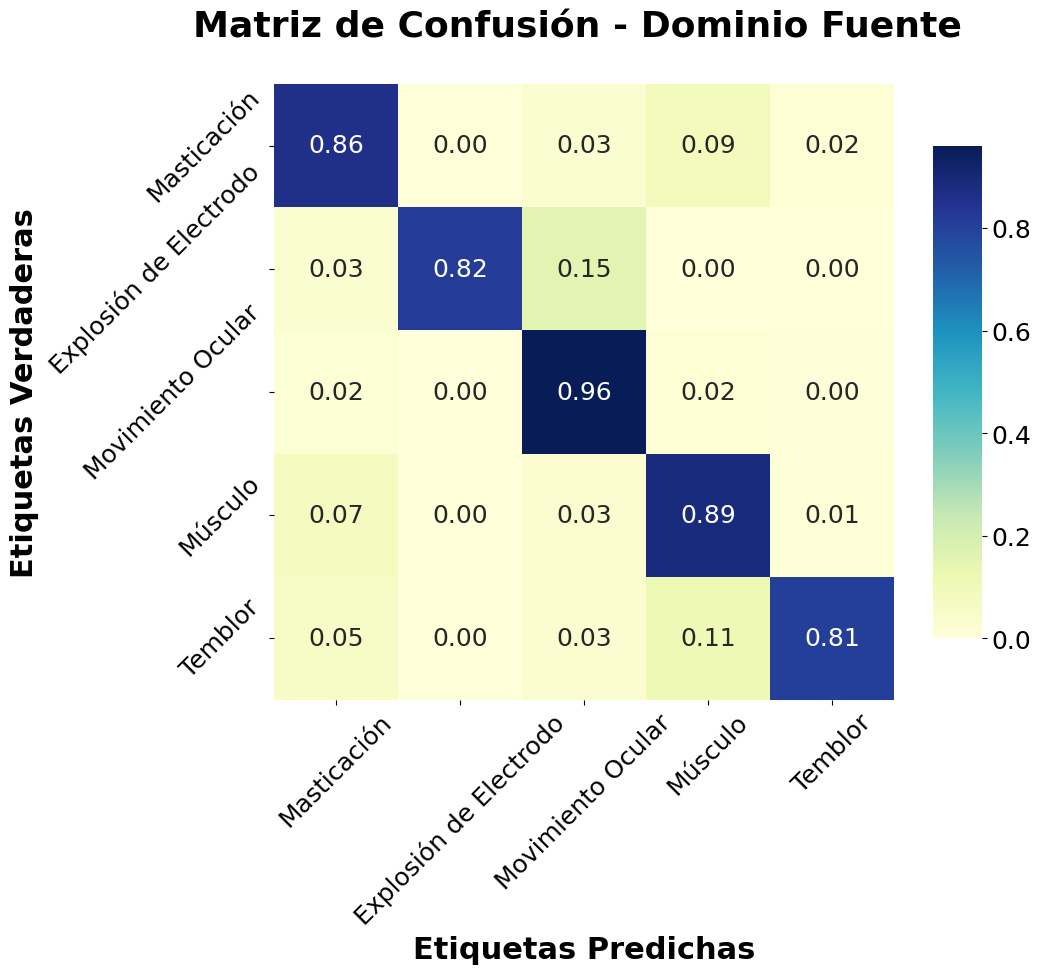

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.71it/s]



Evaluación para el dominio source:
Exactitud General: 0.9161
Precisión General: 0.9252
Sensibilidad General: 0.9024
Puntaje F1 General: 0.9128

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.8693
  - Precisión: 0.8773
  - Sensibilidad: 0.8693
  - Puntaje F1: 0.8733
  - Especificidad: 0.9668
Clase Electrode pop:
  - Exactitud: 0.8788
  - Precisión: 0.9667
  - Sensibilidad: 0.8788
  - Puntaje F1: 0.9206
  - Especificidad: 0.9998
Clase Eye movement:
  - Exactitud: 0.9579
  - Precisión: 0.9317
  - Sensibilidad: 0.9579
  - Puntaje F1: 0.9446
  - Especificidad: 0.9793
Clase Muscle:
  - Exactitud: 0.8826
  - Precisión: 0.8452
  - Sensibilidad: 0.8826
  - Puntaje F1: 0.8635
  - Especificidad: 0.9566
Clase Shiver:
  - Exactitud: 0.8270
  - Precisión: 0.9311
  - Sensibilidad: 0.8270
  - Puntaje F1: 0.8760
  - Especificidad: 0.9919


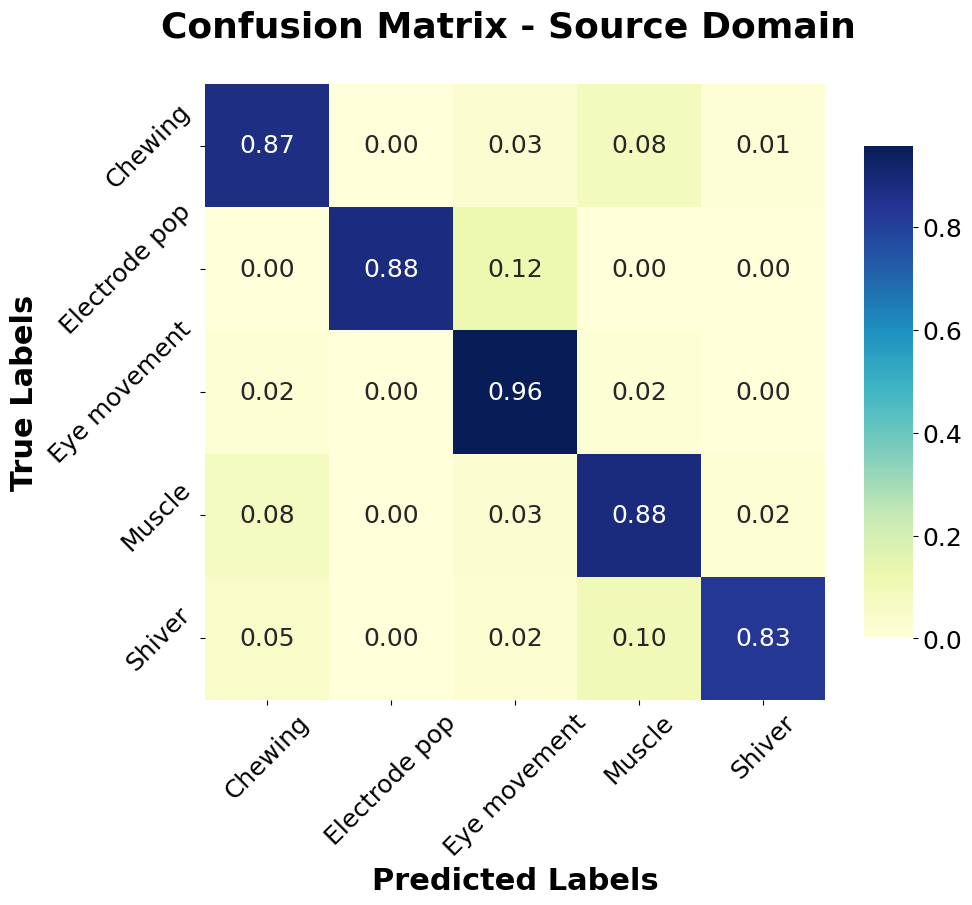

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 508/508 [00:36<00:00, 13.84it/s]



Evaluación para el dominio source:
Exactitud General: 0.9913
Precisión General: 0.9931
Sensibilidad General: 0.9904
Puntaje F1 General: 0.9917

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.9864
  - Precisión: 0.9894
  - Sensibilidad: 0.9864
  - Puntaje F1: 0.9879
  - Especificidad: 0.9972
Clase Explosión de Electrodo:
  - Exactitud: 0.9919
  - Precisión: 1.0000
  - Sensibilidad: 0.9919
  - Puntaje F1: 0.9959
  - Especificidad: 1.0000
Clase Movimiento Ocular:
  - Exactitud: 0.9986
  - Precisión: 0.9792
  - Sensibilidad: 0.9986
  - Puntaje F1: 0.9888
  - Especificidad: 0.9940
Clase Músculo:
  - Exactitud: 0.9863
  - Precisión: 0.9937
  - Sensibilidad: 0.9863
  - Puntaje F1: 0.9900
  - Especificidad: 0.9982
Clase Temblor:
  - Exactitud: 0.9792
  - Precisión: 0.9962
  - Sensibilidad: 0.9792
  - Puntaje F1: 0.9876
  - Especificidad: 0.9995


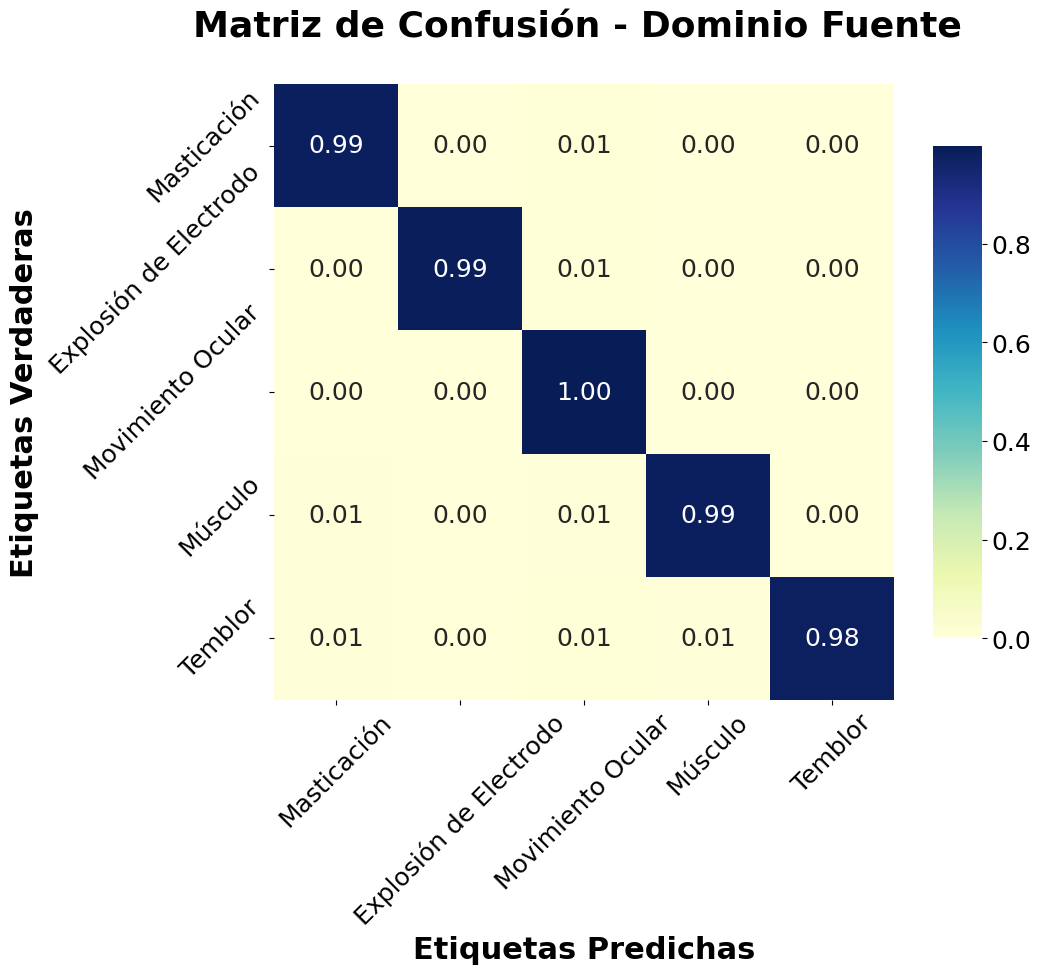

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 508/508 [00:39<00:00, 12.79it/s]



Evaluación para el dominio source:
Exactitud General: 0.9907
Precisión General: 0.9901
Sensibilidad General: 0.9899
Puntaje F1 General: 0.9900

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.9879
  - Precisión: 0.9891
  - Sensibilidad: 0.9879
  - Puntaje F1: 0.9885
  - Especificidad: 0.9971
Clase Electrode pop:
  - Exactitud: 0.9919
  - Precisión: 0.9839
  - Sensibilidad: 0.9919
  - Puntaje F1: 0.9879
  - Especificidad: 0.9999
Clase Eye movement:
  - Exactitud: 0.9986
  - Precisión: 0.9774
  - Sensibilidad: 0.9986
  - Puntaje F1: 0.9879
  - Especificidad: 0.9934
Clase Muscle:
  - Exactitud: 0.9825
  - Precisión: 0.9939
  - Sensibilidad: 0.9825
  - Puntaje F1: 0.9882
  - Especificidad: 0.9983
Clase Shiver:
  - Exactitud: 0.9786
  - Precisión: 0.9962
  - Sensibilidad: 0.9786
  - Puntaje F1: 0.9873
  - Especificidad: 0.9995


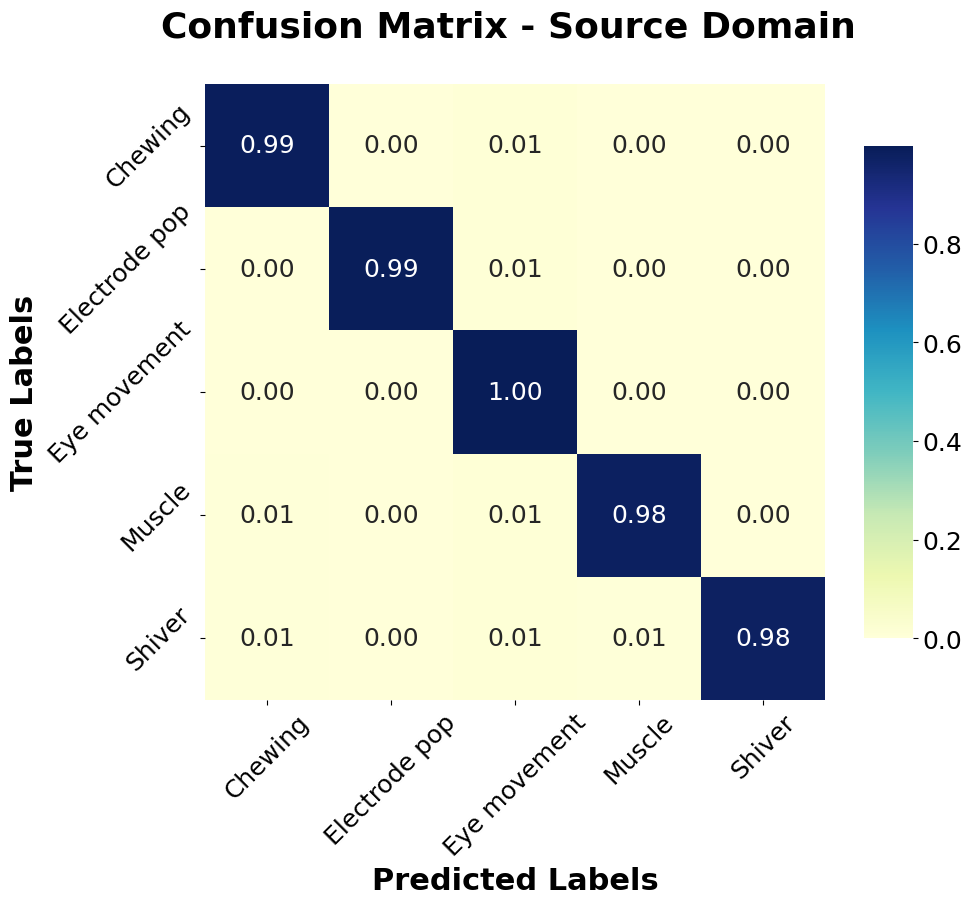

(0.9907065484982767,
 0.9900701461891473,
 0.9899208463476167,
 0.9899551992441312,
 array([0.98908555, 0.98387097, 0.97735952, 0.99390919, 0.99619565]),
 array([0.98791986, 0.99186992, 0.99860647, 0.98248495, 0.97864389]),
 array([0.98850236, 0.98785425, 0.98786876, 0.98816405, 0.98734177]),
 [np.float64(0.9971215185934339),
  np.float64(0.9998759689922481),
  np.float64(0.9934439178515008),
  np.float64(0.9982531364141655),
  np.float64(0.9995130434782609)],
 array([[9.87919859e-01, 0.00000000e+00, 9.13376547e-03, 2.35710077e-03,
         5.89275192e-04],
        [0.00000000e+00, 9.91869919e-01, 8.13008130e-03, 0.00000000e+00,
         0.00000000e+00],
        [8.36120401e-04, 2.78706800e-04, 9.98606466e-01, 0.00000000e+00,
         2.78706800e-04],
        [6.56814450e-03, 0.00000000e+00, 9.85221675e-03, 9.82484948e-01,
         1.09469075e-03],
        [5.33902830e-03, 5.33902830e-04, 8.00854245e-03, 7.47463962e-03,
         9.78643887e-01]]))

In [38]:
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='en')
evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='en')

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.90it/s]



Evaluación para el dominio target:
Exactitud General: 0.9422
Precisión General: 0.9163
Sensibilidad General: 0.9279
Puntaje F1 General: 0.9217

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.9002
  - Precisión: 0.9160
  - Sensibilidad: 0.9002
  - Puntaje F1: 0.9080
  - Especificidad: 0.9774
Clase Explosión de Electrodo:
  - Exactitud: 0.8788
  - Precisión: 0.8056
  - Sensibilidad: 0.8788
  - Puntaje F1: 0.8406
  - Especificidad: 0.9983
Clase Movimiento Ocular:
  - Exactitud: 0.9438
  - Precisión: 0.9765
  - Sensibilidad: 0.9438
  - Puntaje F1: 0.9599
  - Especificidad: 0.9933
Clase Músculo:
  - Exactitud: 0.9523
  - Precisión: 0.9490
  - Sensibilidad: 0.9523
  - Puntaje F1: 0.9507
  - Especificidad: 0.9863
Clase Temblor:
  - Exactitud: 0.8924
  - Precisión: 0.8943
  - Sensibilidad: 0.8924
  - Puntaje F1: 0.8933
  - Especificidad: 0.9861


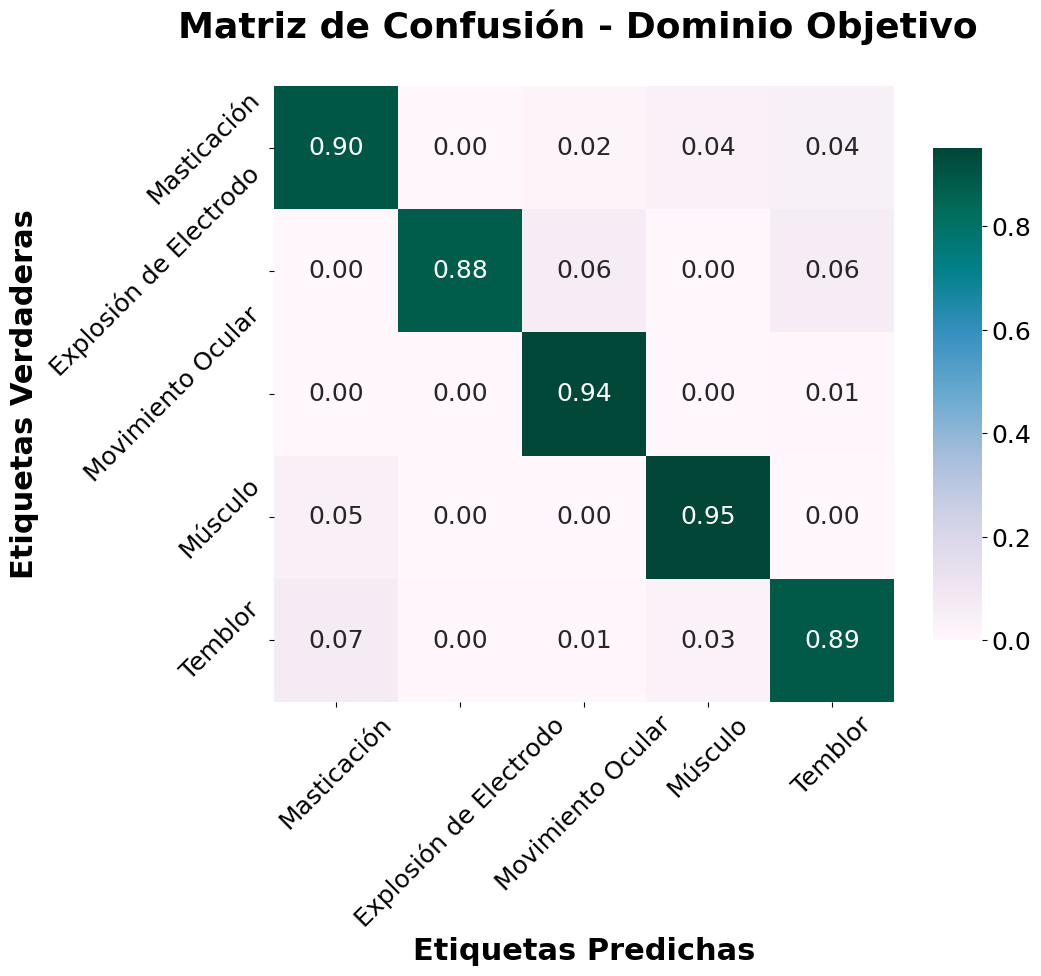

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.93it/s]



Evaluación para el dominio target:
Exactitud General: 0.9422
Precisión General: 0.9163
Sensibilidad General: 0.9279
Puntaje F1 General: 0.9217

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.9002
  - Precisión: 0.9160
  - Sensibilidad: 0.9002
  - Puntaje F1: 0.9080
  - Especificidad: 0.9774
Clase Electrode pop:
  - Exactitud: 0.8788
  - Precisión: 0.8056
  - Sensibilidad: 0.8788
  - Puntaje F1: 0.8406
  - Especificidad: 0.9983
Clase Eye movement:
  - Exactitud: 0.9438
  - Precisión: 0.9765
  - Sensibilidad: 0.9438
  - Puntaje F1: 0.9599
  - Especificidad: 0.9933
Clase Muscle:
  - Exactitud: 0.9523
  - Precisión: 0.9490
  - Sensibilidad: 0.9523
  - Puntaje F1: 0.9507
  - Especificidad: 0.9863
Clase Shiver:
  - Exactitud: 0.8924
  - Precisión: 0.8943
  - Sensibilidad: 0.8924
  - Puntaje F1: 0.8933
  - Especificidad: 0.9861


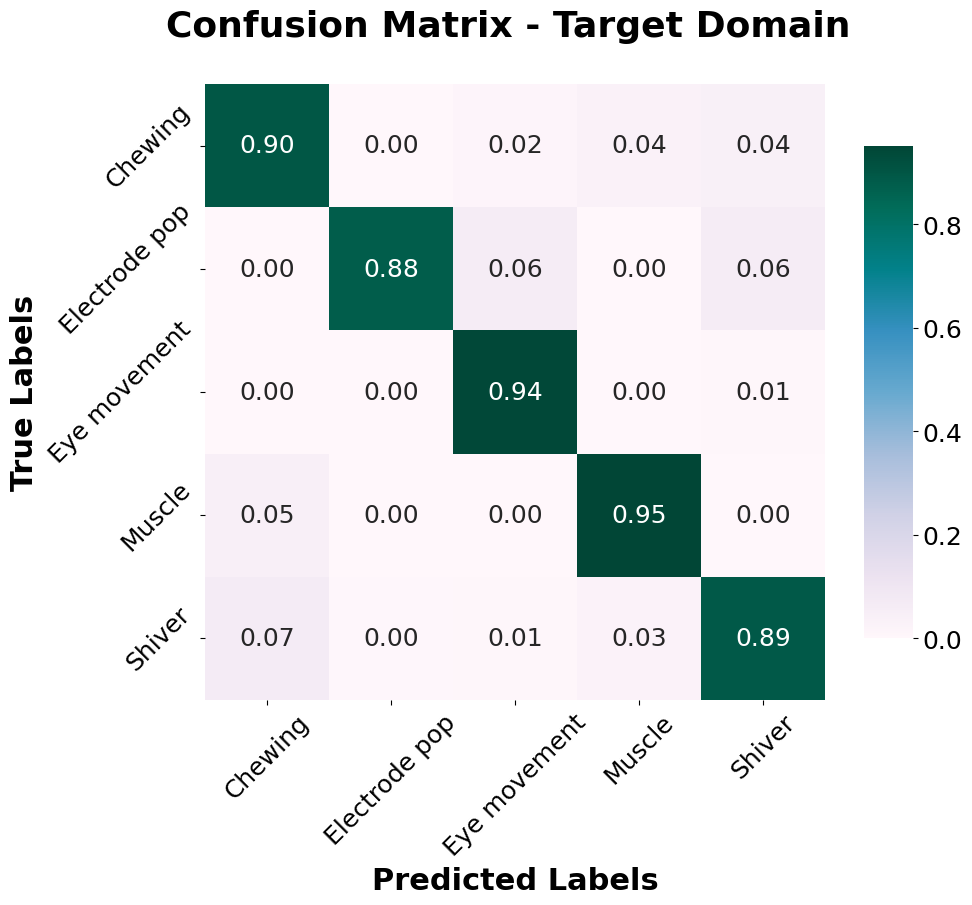

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 508/508 [00:35<00:00, 14.22it/s]



Evaluación para el dominio target:
Exactitud General: 0.9532
Precisión General: 0.9463
Sensibilidad General: 0.9410
Puntaje F1 General: 0.9434

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.9202
  - Precisión: 0.9398
  - Sensibilidad: 0.9202
  - Puntaje F1: 0.9299
  - Especificidad: 0.9844
Clase Explosión de Electrodo:
  - Exactitud: 0.9024
  - Precisión: 0.9407
  - Sensibilidad: 0.9024
  - Puntaje F1: 0.9212
  - Especificidad: 0.9996
Clase Movimiento Ocular:
  - Exactitud: 0.9465
  - Precisión: 0.9759
  - Sensibilidad: 0.9465
  - Puntaje F1: 0.9610
  - Especificidad: 0.9934
Clase Músculo:
  - Exactitud: 0.9699
  - Precisión: 0.9726
  - Sensibilidad: 0.9699
  - Puntaje F1: 0.9712
  - Especificidad: 0.9921
Clase Temblor:
  - Exactitud: 0.9076
  - Precisión: 0.8933
  - Sensibilidad: 0.9076
  - Puntaje F1: 0.9004
  - Especificidad: 0.9859


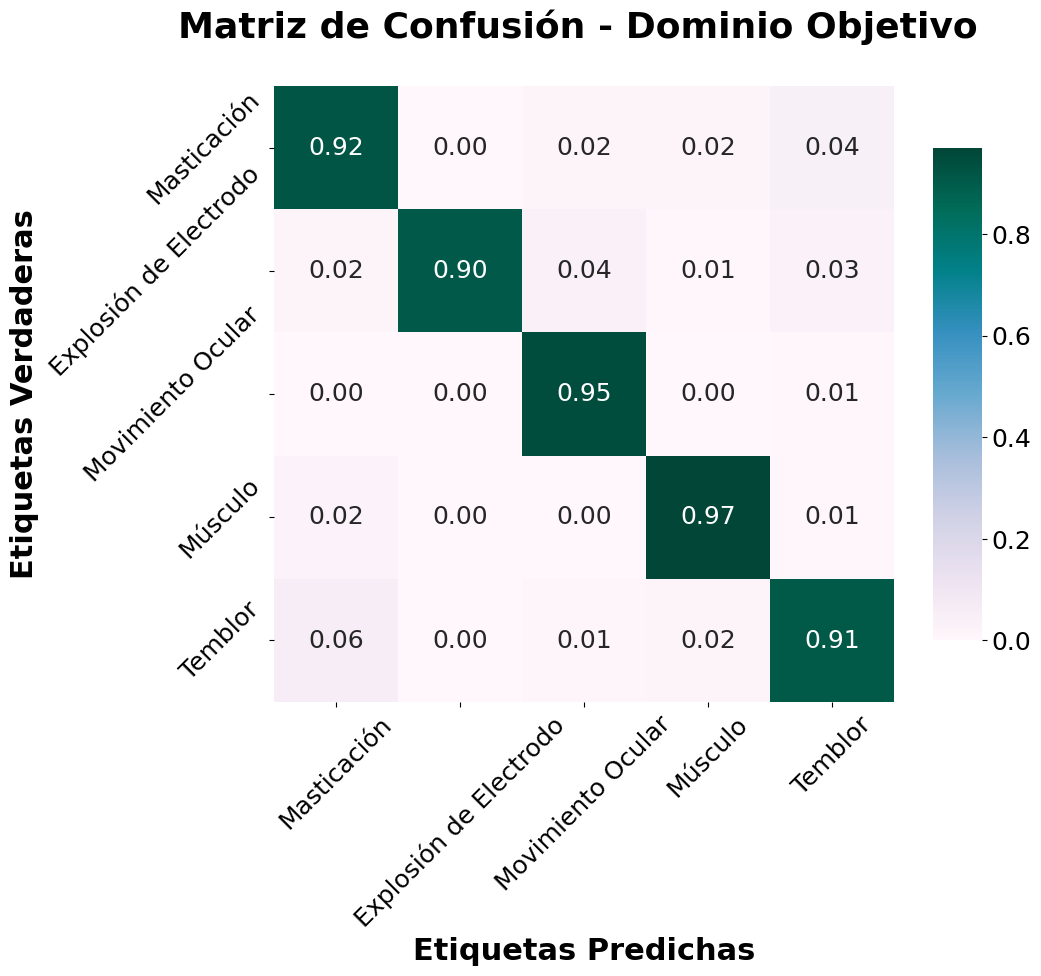

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 508/508 [00:37<00:00, 13.50it/s]



Evaluación para el dominio target:
Exactitud General: 0.9532
Precisión General: 0.9463
Sensibilidad General: 0.9410
Puntaje F1 General: 0.9434

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.9202
  - Precisión: 0.9398
  - Sensibilidad: 0.9202
  - Puntaje F1: 0.9299
  - Especificidad: 0.9844
Clase Electrode pop:
  - Exactitud: 0.9024
  - Precisión: 0.9407
  - Sensibilidad: 0.9024
  - Puntaje F1: 0.9212
  - Especificidad: 0.9996
Clase Eye movement:
  - Exactitud: 0.9465
  - Precisión: 0.9759
  - Sensibilidad: 0.9465
  - Puntaje F1: 0.9610
  - Especificidad: 0.9934
Clase Muscle:
  - Exactitud: 0.9699
  - Precisión: 0.9726
  - Sensibilidad: 0.9699
  - Puntaje F1: 0.9712
  - Especificidad: 0.9921
Clase Shiver:
  - Exactitud: 0.9076
  - Precisión: 0.8933
  - Sensibilidad: 0.9076
  - Puntaje F1: 0.9004
  - Especificidad: 0.9859


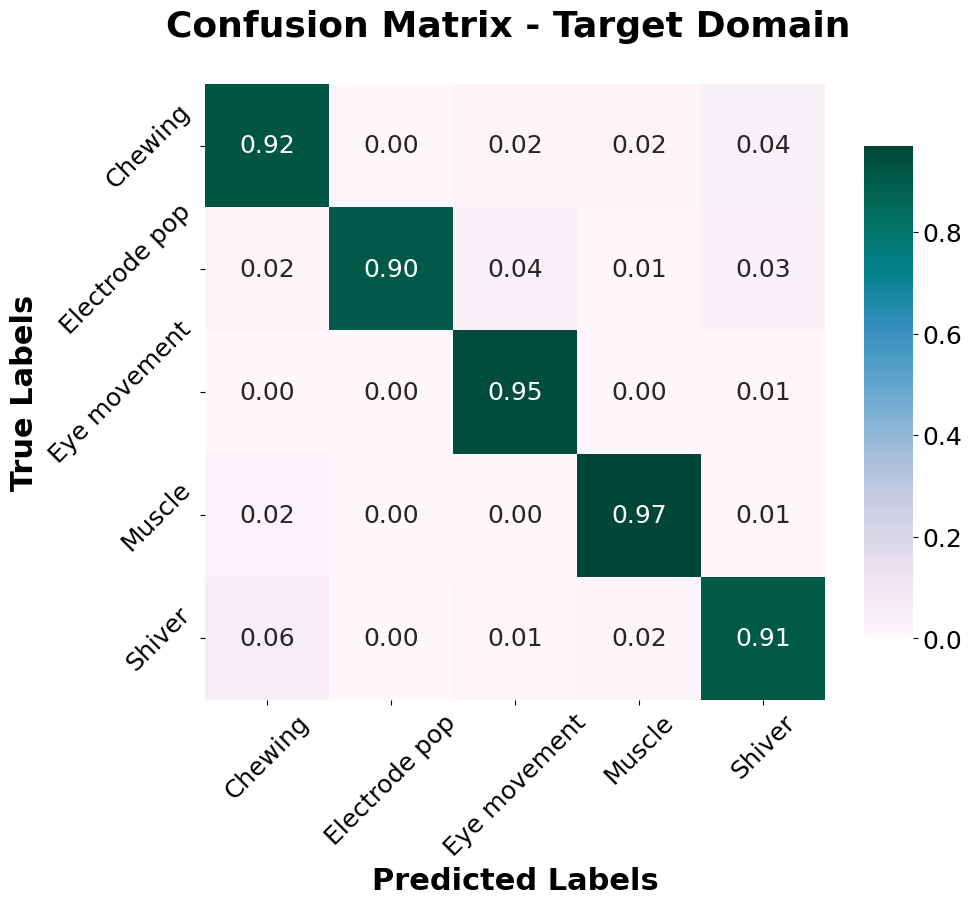

(0.953163466272772,
 0.9463429197209635,
 0.9409636165133297,
 0.9434425541057041,
 array([0.93981342, 0.94067797, 0.97586207, 0.97255763, 0.89332633]),
 array([0.92015321, 0.90243902, 0.94648829, 0.969896  , 0.90763481]),
 array([0.92987941, 0.92116183, 0.96095076, 0.97122499, 0.90042373]),
 [np.float64(0.9844406410455889),
  np.float64(0.9995658914728682),
  np.float64(0.9933649289099526),
  np.float64(0.9920597109734794),
  np.float64(0.9858782608695652)],
 array([[9.20153212e-01, 2.94637596e-04, 1.53211550e-02, 1.82675309e-02,
         4.47849146e-02],
        [1.62601626e-02, 9.02439024e-01, 4.06504065e-02, 8.13008130e-03,
         3.25203252e-02],
        [5.57413601e-04, 1.39353400e-03, 9.46488294e-01, 0.00000000e+00,
         6.96767001e-03],
        [2.38095238e-02, 0.00000000e+00, 2.73672687e-04, 9.69896004e-01,
         6.02079912e-03],
        [5.81954084e-02, 5.33902830e-04, 1.22797651e-02, 1.97544047e-02,
         9.07634810e-01]]))

In [39]:
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='en')
evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='en')

In [8]:
import pandas as pd
sns.set_style("darkgrid")

def plot_training_metrics(csv_path, language='en', save_path=None, y_min=0.0, y_max=1.0):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Source Acc'], label='Exactitud de Entrenamiento (Fuente)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Exactitud de Entrenamiento (Objetivo)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Exactitud de Validación (Fuente)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Exactitud de Validación (Objetivo)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Entrenamiento y Validación de Exactitud\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Exactitud', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Source Acc'], label='Training Accuracy (Source)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Training Accuracy (Target)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Validation Accuracy (Source)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Validation Accuracy (Target)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Training and Validation Accuracy\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
    
    plt.ylim(0.5, 1)
    plt.xticks(ticks=range(0, len(df.index) + 5, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower right', fontsize=14, labelspacing=1.5, borderpad=1.5, frameon=True, fancybox=True)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


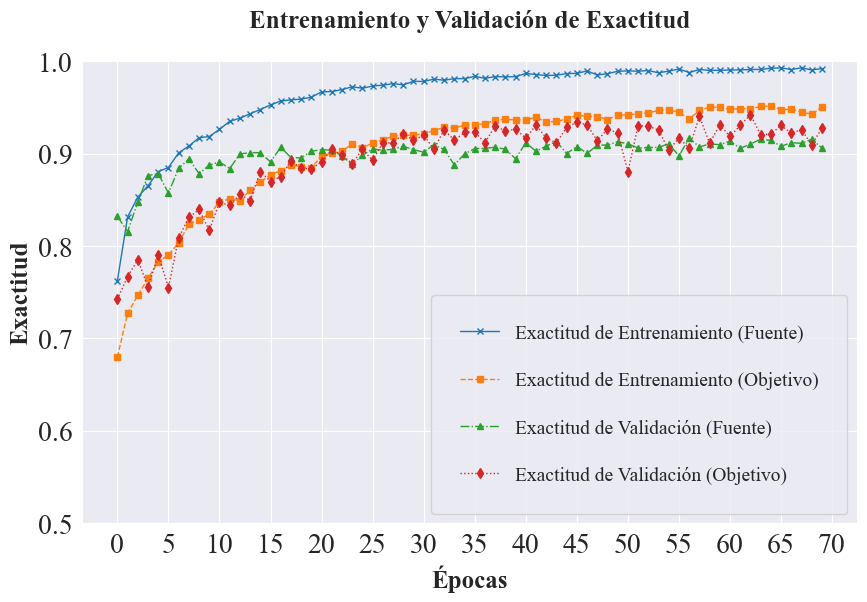

In [9]:
plot_training_metrics('training_metrics_stft.csv', language='es')

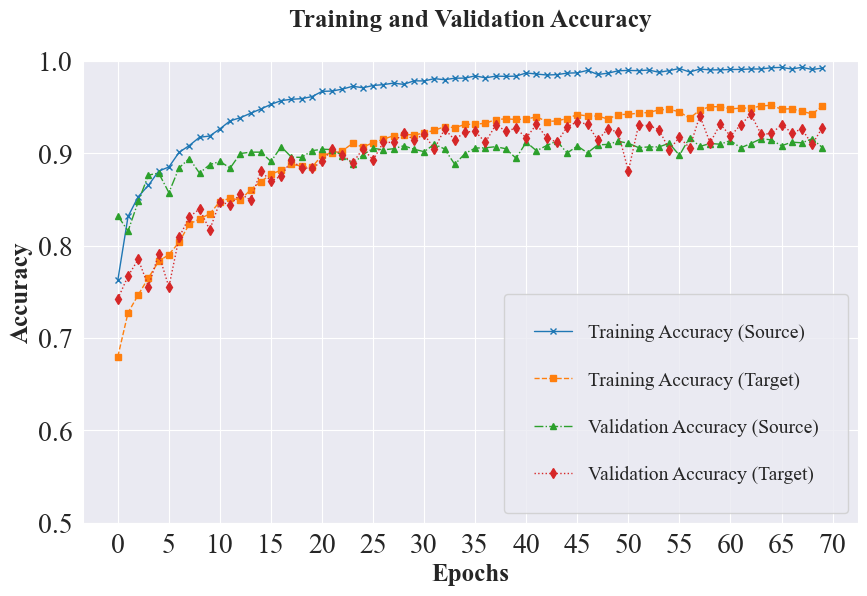

In [10]:
plot_training_metrics('training_metrics_stft.csv', language='en')

In [11]:
def plot_domain_adaptation_loss(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Loss'], label='Pérdida de Adaptación de Dominio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Pérdida de Adaptación de Dominio\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Pérdida', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Loss'], label='Domain Adaptation Loss', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Domain Adaptation Loss\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Loss', fontsize=18, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=18)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

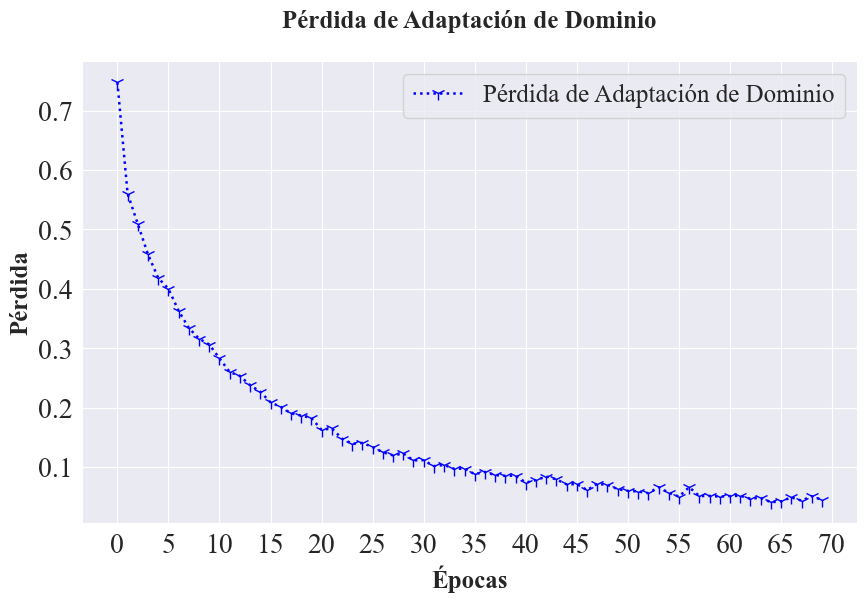

In [12]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='es')

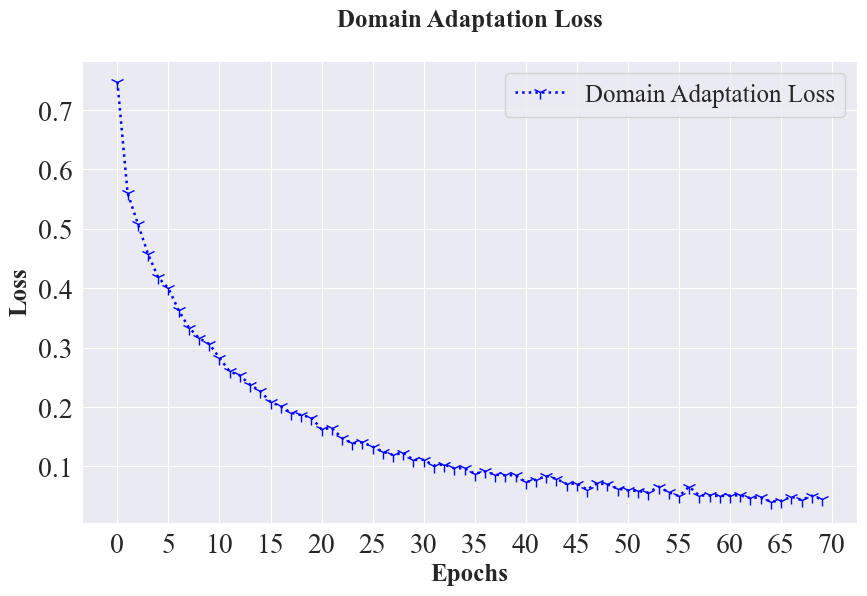

In [13]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='en')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_divergence_metrics(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))

    if language == 'es':
        plt.plot(df.index, df['Avg KL Divergence'], label='Divergencia KL Promedio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Divergencia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Distancia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)
        
        plt.title('Métricas de Divergencia y Distancia\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epocas', fontsize=18, fontweight='bold')
        plt.ylabel('Valores', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Avg KL Divergence'], label='Avg KL Divergence', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Avg Jensen-Shannon Divergence', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Avg Jensen-Shannon Distance', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)
        
        plt.title('Domain Adaptation Distance and Divergence Metrics\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Values', fontsize=18, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    
    y_min = int(df[['Avg KL Divergence', 'Avg Jensen-Shannon Divergence', 'Avg Jensen-Shannon Distance']].min().min())
    y_max = int(df[['Avg KL Divergence', 'Avg Jensen-Shannon Divergence', 'Avg Jensen-Shannon Distance']].max().max())
    plt.yticks(ticks=range(y_min, y_max + 1, 1), fontsize=20)
    
    plt.legend(loc='upper right', fontsize=18)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


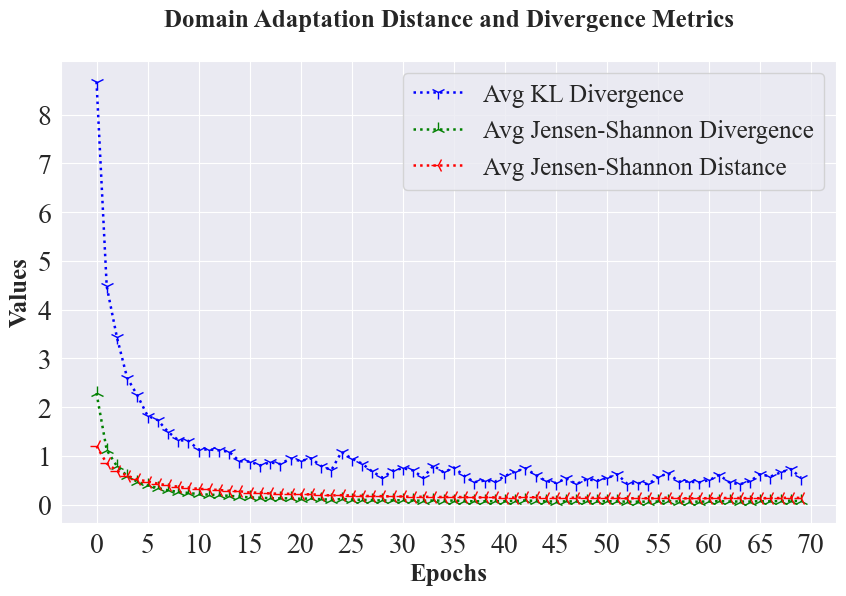

In [15]:
plot_divergence_metrics('divergence_metrics_stft.csv', language='en')

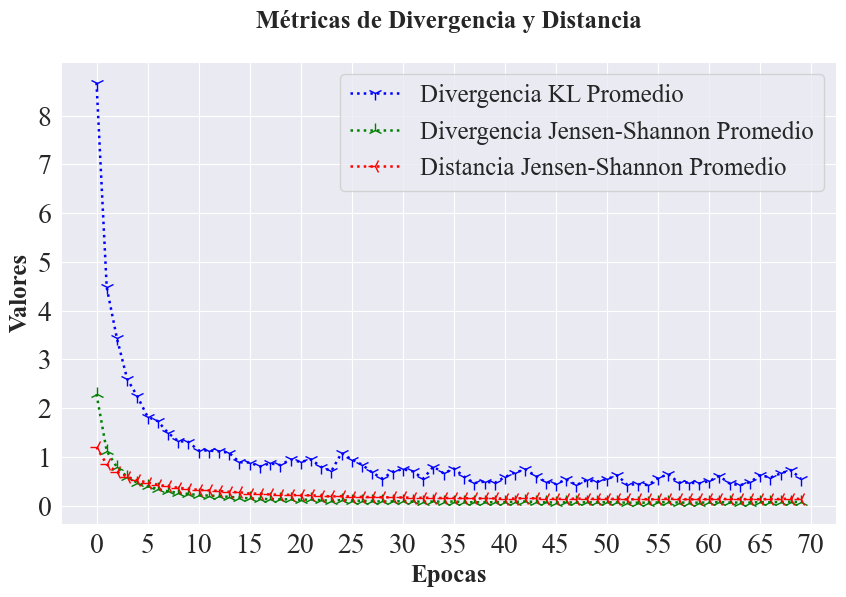

In [16]:
plot_divergence_metrics('divergence_metrics_stft.csv', language='es')